Author: Aleksandra Dmitruka, ad22069
===========================

Note: This is a solution for given task. Nothing extra included or explained

#1. Module/library import

In [ ]:
#Imports the modules needed
from google.colab import files
import pandas as pd
import torch
from torch import nn
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from tabulate import tabulate
import numpy as np



#2. File uploading

In [ ]:
# Call up the file upload dialog and select the files Iris_train.csv and Iris_validate.csv
uploaded = files.upload()

# Checks if files are found on Google Colab drive (file operations can be done using Bash commands prefixed with '!')
!ls

Saving Iris_validate.csv to Iris_validate.csv
Saving Iris_train.csv to Iris_train.csv
Iris_train.csv	Iris_validate.csv  sample_data


#3. Data preparation

In [ ]:
# test_data will be used by the instructor to check the results, leave this comment
# test_data = pd.read_csv("Iris_test.csv")


class IrisDataset(data.Dataset):


    """
    PyTorch dataset class for loading the Iris dataset. Turns data into an understndable format for neural network

    Args:
        name (str): The filename of the CSV containing the Iris dataset.

    Attributes:
        data (DataFrame): The pandas DataFrame containing the Iris dataset.
        label_encoder (LabelEncoder): The label encoder used to encode the target labels (0,1,2).
        features (Tensor): The tensor containing the input features.
        labels (Tensor): The tensor containing the target labels.

    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(idx): Retrieves the features and label of the specified index.
    """


    def __init__(self,name):

        """
        Initializes the IrisDataset by loading the dataset from a CSV file and encoding the labels.

        Args:
            name (str): The filename of the CSV containing the Iris dataset.
        """

        super().__init__()
        self.data= pd.read_csv(name)
        self.label_encoder = LabelEncoder()
        self.data['Species'] = self.label_encoder.fit_transform(self.data['Species'])
        self.features = torch.tensor(self.data.iloc[:, :-1].values,dtype=torch.float32)
        self.labels =torch.tensor(self.data.iloc[:, -1].values, dtype=torch.float32)



    def __len__(self):

        """
        Returns the length of the choosen dataset.

        Returns:
            int: The number of samples in the dataset(excluding data lables).
        """

        return len(self.data)



    def __getitem__(self, idx):

      """
        Retrieves the features and label at the specified index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the features tensor and the label tensor.
      """

      features =self.features[idx]
      label = self.labels[idx]

      return features, label


# The original training dataset, that is shuffeled
dataset = IrisDataset("Iris_train.csv")
data_loader = data.DataLoader(dataset, batch_size=1, shuffle=True)

# The validation dataset, that is NOT shuffeled
validation_dataset=IrisDataset("Iris_validate.csv")
validation_loader = data.DataLoader(validation_dataset, batch_size=1, shuffle=False)

#dataset.data



#4. Defining a Neural Network

In [ ]:
# Note: 2 linear layers+ activation function worked fine but a bit worse

class IrisModel(nn.Module):

    """
    PyTorch neural network model for classifying Iris dataset.

    Args:
        num_inputs (int): Number of input features(in our case 4).
        num_hidden (int): Number of units in the first hidden layer.
        num_hidden2 (int): Number of units in the second hidden layer.
        num_outputs (int): Number of output classes(in our case 3).

    Attributes:
        linear_1 (nn.Linear): First linear layer.
        linear_2 (nn.Linear): Second linear layer.
        linear_3 (nn.Linear): Third linear layer.

    Methods:
        forward(x): Performs forward pass through the neural network.
    """


    def __init__(self, num_inputs,num_hidden,num_hidden2, num_outputs):

        """
        Initializes the IrisModel with specified layer sizes.

        Args:
            num_inputs (int): Number of input features.
            num_hidden (int): Number of units in the first hidden layer.
            num_hidden2 (int): Number of units in the second hidden layer.
            num_outputs (int): Number of output classes.

        """
        super().__init__()
        self.linear_1 = nn.Linear(num_inputs, num_hidden)
        self.linear_2 = nn.Linear(num_hidden, num_hidden2)
        self.linear_3= nn.Linear(num_hidden2, num_outputs)



    def forward(self, x):

        """
        Performs forward pass through the neural network. Uses ReLu activation functions to adjust non-linearity
        The softmax function is used to normalize results and later output a readable vector (with the with a clear division of 1.0 or 100% into 3 classes)

        Args:
        x (torch.Tensor): Input tensor.

        Returns:
        x (torch.Tensor): Output tensor containing class probabilities.
        """
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = self.linear_3(x) # author have experimented with using sigmoid or relu here, the results were worse. So no activation here
        x = F.softmax(x, dim=1)
        return x

#5. Neural network training

In [ ]:
torch.manual_seed(42) #for constant result


model_flower = IrisModel(num_inputs=4, num_hidden=10,num_hidden2=8, num_outputs=3) # we input 4 features and want one of 3 classes


model_flower.train()

# recomended optimizer and loss function for clasification tasks (lecture theory about classificators)
optimizer = torch.optim.Adam(model_flower.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

num_epochs=100
# choosen from experiment in a 'harder' notebook version. The fastest approach - 50 epoches, the safest - 100 (see picture at the end of the file)
# The author have chosen the safest(100) because on different divices the best was in a range 50-80 epoches, hovewer everything from 100 was stabely low and had no fluctuations


# actual model training block
for epoch in range(num_epochs):
    train_loss = 0.0
    for features, label in data_loader:

        outputs = model_flower(features) # Forward pass: compute predicted outputs

        loss = loss_function(outputs, label.long())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()  # Performs a model parameter update

        train_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(data_loader)}') # by deviding we get a more realistic and understandable represenation of loss for all data in each epoch


Epoch 1 		 Training Loss: 1.0943391881291828
Epoch 2 		 Training Loss: 1.0823487932719882
Epoch 3 		 Training Loss: 1.064649371400712
Epoch 4 		 Training Loss: 1.0373566472341145
Epoch 5 		 Training Loss: 1.01373419638664
Epoch 6 		 Training Loss: 0.9957833905068655
Epoch 7 		 Training Loss: 0.9826307150106581
Epoch 8 		 Training Loss: 0.9709358891797444
Epoch 9 		 Training Loss: 0.960987432135476
Epoch 10 		 Training Loss: 0.9515472328852094
Epoch 11 		 Training Loss: 0.9423920715612079
Epoch 12 		 Training Loss: 0.9353102625362457
Epoch 13 		 Training Loss: 0.927151912734622
Epoch 14 		 Training Loss: 0.91914839593191
Epoch 15 		 Training Loss: 0.9115053386915297
Epoch 16 		 Training Loss: 0.9054669681049529
Epoch 17 		 Training Loss: 0.8976161120429872
Epoch 18 		 Training Loss: 0.8913002827810863
Epoch 19 		 Training Loss: 0.8847011072295052
Epoch 20 		 Training Loss: 0.8786589612090399
Epoch 21 		 Training Loss: 0.8736369411150614
Epoch 22 		 Training Loss: 0.8678690204544673
Epoc

# 6. Testing a neural network.
The results of all tests should be printed in an easy-to-understand format (12 lines, one for each example in the validation set), as well as an overall accuracy rating.
  Design example:

  Line 1: Classifier result: Iris-setosa; actual species: Iris-setosa, correct
  ...
  
  Line 12: classifier result: Iris-versicolor; real species: Iris-virginica, wrong
  
  Accuracy: 58% (7/12)

In [ ]:
model_flower.eval()

validation_loss = 0.0
correct_predictions = 0
total_predictions = 0


#Dicrionary to de-code results
class_to_species = {
    0: 'Iris-setosa',
    1: 'Iris-versicolor',
    2: 'Iris-virginica'
}



#Put any test dataset from dataloader here
test_data=validation_loader

table_data = []


# The torch.no_grad is not obligatory and most probably is not needed for such a small dataset
# However it is a good practise for memory saving when evaluating a model, so it was included
with torch.no_grad():
    for features, labels in test_data:
        outputs = model_flower(features)
        loss = loss_function(outputs, labels.long())
        validation_loss += loss.item()

        _, predicted = torch.max(outputs, 1) # the the tensor position where "probability" is the highest
        predicted_species = class_to_species[predicted.item()]
        real_species = class_to_species[labels.item()]
        is_correct = (predicted.item() == labels.item())

        correct_predictions += is_correct
        total_predictions += 1

        # Flatten the output vector(tensor) and convert it to a string representation without scientific notation
        output_str = ", ".join(["{:.4f}".format(float(value)) for value in outputs.flatten().numpy()])


        table_data.append([total_predictions+1, output_str, predicted_species, real_species, "True" if is_correct else "False"])

#table created with tabulate library
#Output vector is a name for a string from result(output) tensor
print(tabulate(table_data, headers=["CSV_Line_Num", "    Output Vector", "Classificator result", "Real result", "Correct"],tablefmt='grid'))



validation_loss /= len(test_data) # by deviding we get a more realistic and understandable represenation of loss for all data


print(f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {((correct_predictions)/ total_predictions)*100} % or {correct_predictions}/{total_predictions}')



+----------------+------------------------+------------------------+-----------------+-----------+
|   CSV_Line_Num |     Output Vector      | Classificator result   | Real result     | Correct   |
+================+========================+========================+=================+===========+
|              2 | 0.9997, 0.0003, 0.0000 | Iris-setosa            | Iris-setosa     | True      |
+----------------+------------------------+------------------------+-----------------+-----------+
|              3 | 0.9996, 0.0004, 0.0000 | Iris-setosa            | Iris-setosa     | True      |
+----------------+------------------------+------------------------+-----------------+-----------+
|              4 | 0.9997, 0.0003, 0.0000 | Iris-setosa            | Iris-setosa     | True      |
+----------------+------------------------+------------------------+-----------------+-----------+
|              5 | 0.9997, 0.0003, 0.0000 | Iris-setosa            | Iris-setosa     | True      |
+---------

# Picture: Epoch experiment 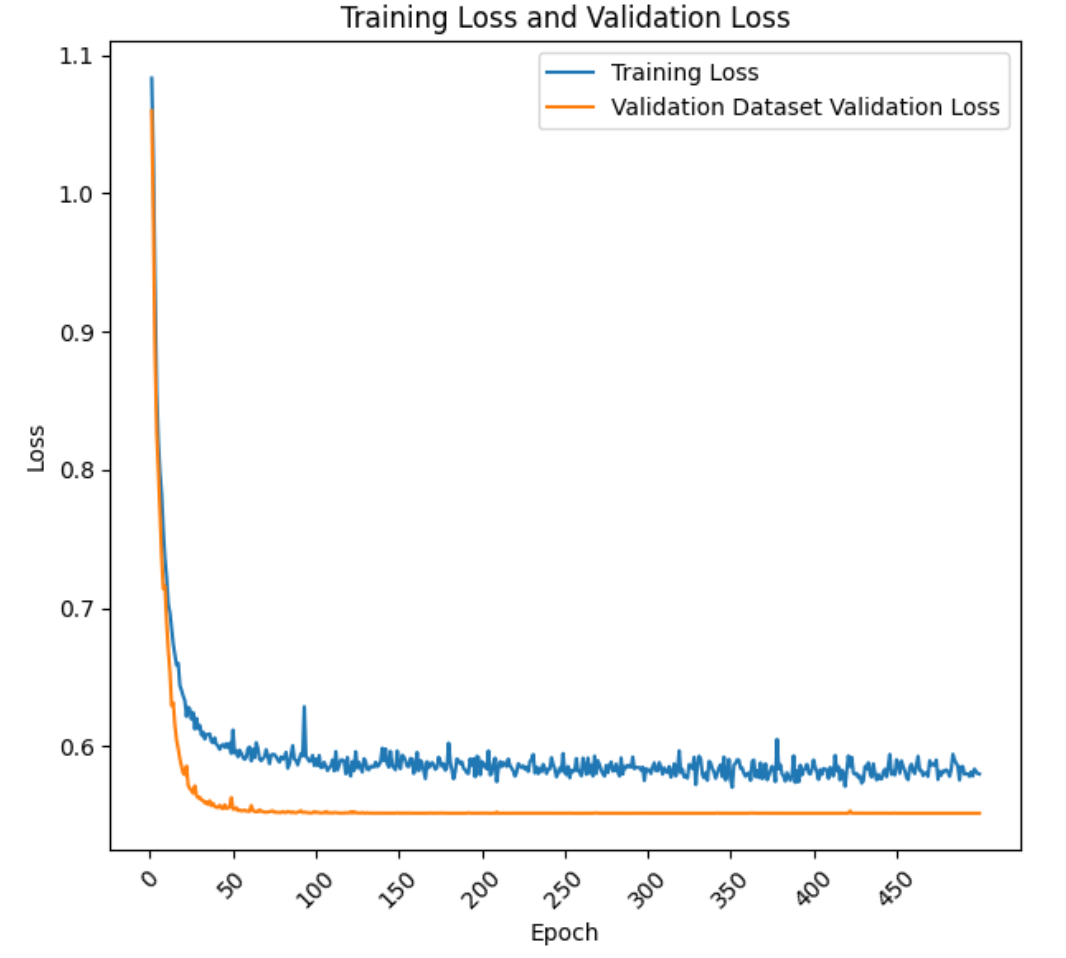